In [1]:
#!7z x Recipe-feature_map.7z
#!7z x user-rating_matrix.7z

This notebook contains the implementation of the CTRMF recipe recommendation model.

In [2]:
import torch

# Use GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

We have saved our data using numpy's save feature, and load it into this notebook for training. Our data consists of a recipe-feature matrix, where the rows correspond to recipes and the columns correspond to recipe features. Features include ingredients, cooking style, and other recipe metadata. We also have a user-rating matrix, which stores the ratings data.

In [3]:
import numpy as np

def get_user_rating_matrix(path='./user-rating_matrix.npy'):
	return np.load(path)

def get_recipe_feature_map(path='./Recipe-feature_map.npy'):
	return np.load(path).T

# Load the user-ratings and recipe-feature matrices
ur = get_user_rating_matrix()
rf = get_recipe_feature_map()

In [4]:
# Split data into train and test sets
def split_to_train_test(user_ratings, recipe_feature, test_percentage):
    total_columns = user_ratings.shape[1]
    test_column_count = round(test_percentage*total_columns)
    ur_train = user_ratings[:, :-test_column_count]
    ur_test = user_ratings[:, -test_column_count:]
    rf_train = recipe_feature[:-test_column_count, :]
    rf_test = recipe_feature[-test_column_count:, :]
    return ur_train, ur_test, rf_train, rf_test

ur_train, ur_test, rf_train, rf_test = split_to_train_test(ur, rf, .2)
ur_train, ur_val, rf_train, rf_val = split_to_train_test(ur_train, rf_train, .2)

In [5]:
from torch.utils.data import Dataset, DataLoader

# Create RatingDataset class to help with loading data
class RatingDataset(Dataset):
    def __init__(self, user_ratings):
        self.user_ratings = user_ratings
        self.row_indices, self.col_indices = user_ratings.nonzero()
	
    def __len__(self):
        return len(self.row_indices)
	
    def __getitem__(self, idx):
        row = self.row_indices[idx]
        col = self.col_indices[idx]
        rating = self.user_ratings[row, col]
        return torch.LongTensor([row]).to(device), \
            torch.LongTensor([col]).to(device), \
            torch.FloatTensor([rating]).to(device)

batch_size = 1000
train_loader = DataLoader(RatingDataset(ur_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(RatingDataset(ur_val), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(RatingDataset(ur_test), batch_size=batch_size, shuffle=True)

# Model

Here we define the model. The implementation is similar to standard Matrix Factorization (MF) as it involves factorizing the user-rating matrix into several matrices. We use pytorch's `torch.nn.Embedding` layer to represent each matrix, as essentially its weights are in the form of a 2D tensor which we can use for our computations.

In [6]:
import torch
import torch.nn as nn

class CTRMF(nn.Module):
    def __init__(self,
        ratings_data,
        recipe_feature,
        n_hidden=80,
        reg_term=0.01,
        device=None,
        verbose=False):
        """
        ratings_data : ((n_users, n_recipes) 2D array)
            Collection of recipe ratings for each user.
        recipe_feature : ((n_recipes, n_features) 2D array)
            Recipe-feature matrix, where each element is 1 if the recipe
            contains the corresponding feature, 0 otherwise.
        n_hidden : (Integer)
            Number of latent dimensions
        reg_term : (Double)
            Regularization term
        verbose : (Boolean)
            Prints helpful training progress messages if True
        """
        super(CTRMF, self).__init__()
        
        self.ratings_data = ratings_data
        self.recipe_feature = torch.FloatTensor(recipe_feature).to(device)
        self.n_hidden = n_hidden
        self.n_users, self.n_recipes = ratings_data.shape
        self.n_features = recipe_feature.shape[1]
        self.reg_term = reg_term
        self.verbose = verbose
        
        # Set learned matrices as Embeddings
        self.user_hidden = nn.Embedding(
            self.n_users,
            self.n_hidden
        ).to(device)
        self.hidden_feature = nn.Embedding(
            self.n_hidden,
            self.n_features
        ).to(device)
        self.user_biases = nn.Embedding(self.n_users, 1).to(device)
        self.recipe_biases = nn.Embedding(self.n_recipes, 1).to(device)
        
        # Initialize learned matrices
        nn.init.xavier_uniform_(self.user_hidden.weight)
        nn.init.xavier_uniform_(self.hidden_feature.weight)
        self.user_biases.weight.data.fill_(0.)
        self.recipe_biases.weight.data.fill_(0.)
        
        # Calculate the mean of the ratings data
        self.global_bias = torch.FloatTensor([np.mean(
            self.ratings_data[np.where(self.ratings_data != 0)]
        )]).to(device)
        
        if self.verbose:
            print("Initializing ctrmf")
            print("==================")
            print(f"n_users: {self.n_users}")
            print(f"n_recipes: {self.n_recipes}")
            print(f"recipe_feature.shape: {recipe_feature.shape}")
            print(f"n_features: {self.n_features}")
            print(f"n_hidden: {self.n_hidden}")
            print(f"user_hidden.shape: ({self.user_hidden.num_embeddings},{self.user_hidden.embedding_dim})")
            print(f"hidden_feature.shape: {self.hidden_feature.weight.shape}")
            print('\n')

    def forward(self, user, recipe):
        pred = torch.matmul(self.user_hidden(user), self.hidden_feature.weight)
        pred = torch.matmul(pred, self.recipe_feature[recipe].T)
        pred += self.user_biases(user) + self.recipe_biases(recipe) + self.global_bias
        return pred

In [7]:
model = CTRMF(
    ur,
    rf,
    device=device,
    verbose=True
).to(device)

Initializing ctrmf
n_users: 1000
n_recipes: 40818
recipe_feature.shape: (40818, 773)
n_features: 773
n_hidden: 80
user_hidden.shape: (1000,80)
hidden_feature.shape: torch.Size([80, 773])




# Training

Here we perform our training, in standard PyTorch style.

In [8]:
import torch.optim as optim

# Use MSE as the loss function
criterion = nn.MSELoss()

# Use SGD to optimize the weights
optimizer = optim.Adam(model.parameters(), lr=1e-3)

[epoch:0] Train MSE: 0.6340022662691042, Validation MSE: 0.6059945767576044
[epoch:1] Train MSE: 0.5819040753093421, Validation MSE: 0.6108713193373246
[epoch:2] Train MSE: 0.5479124397331593, Validation MSE: 0.6218348362229087
[epoch:3] Train MSE: 0.5148029860620406, Validation MSE: 0.6365656354210594
[epoch:4] Train MSE: 0.4822184196582027, Validation MSE: 0.6538974035869946
[epoch:5] Train MSE: 0.4513000384265301, Validation MSE: 0.6739446108991449
[epoch:6] Train MSE: 0.42280670854390834, Validation MSE: 0.6934847235679626
[epoch:7] Train MSE: 0.3971717375166276, Validation MSE: 0.715198528766632
[epoch:8] Train MSE: 0.3743409141898155, Validation MSE: 0.7380870428952304
[epoch:9] Train MSE: 0.35416333990938526, Validation MSE: 0.7588088674978777


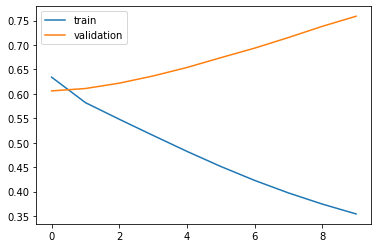

Finished training!
Best validation loss: 0.6059945767576044


In [9]:
import copy
from matplotlib import pyplot as plt

epochs = 10

best_model = None
best_mse = 1000
train_mse = []
val_mse = []

for epoch in range(epochs):
    train_loss_tot = 0.
    train_ctr = 0
    for row_batch, col_batch, rating_batch in train_loader:
        optimizer.zero_grad()
        
        # Predict rating and calculate loss
        prediction = model(row_batch.squeeze(), col_batch.squeeze())
        prediction = torch.diagonal(prediction)
        loss = criterion(prediction, rating_batch.squeeze())
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Update loss total
        train_loss_tot += loss.item()
        train_ctr += 1
    
    val_loss_tot = 0.
    val_ctr = 0
    with torch.no_grad():
        for row_batch, col_batch, rating_batch in val_loader:
            # Predict rating and calculate loss
            prediction = model(row_batch.squeeze(), col_batch.squeeze())
            prediction = torch.diagonal(prediction)
            loss = criterion(prediction, rating_batch.squeeze())
            
            # Update loss total
            val_loss_tot += loss.item()
            val_ctr += 1
        
    train_mse += [train_loss_tot / train_ctr]
    val_mse += [val_loss_tot / val_ctr]

    print('[epoch:{}] Train MSE: {}, Validation MSE: {}'.format(
        epoch,
        train_mse[-1],
        val_mse[-1]
    ))
    if val_mse[-1] < best_mse:
        best_mse = val_mse[-1]
        best_model = copy.deepcopy(model)

plt.plot(train_mse, label='train')
plt.plot(val_mse, label='validation')
plt.legend()
plt.show()
print('Finished training!')
print('Best validation loss: {}'.format(best_mse))
model = best_model
    

In [11]:
from math import sqrt

test_loss_tot = 0.
test_ctr = 0
with torch.no_grad():
    for row_batch, col_batch, rating_batch in test_loader:
        # Predict rating and calculate loss
        prediction = model(row_batch.squeeze(), col_batch.squeeze())
        prediction = torch.diagonal(prediction)
        loss = criterion(prediction, rating_batch.squeeze())
        
        # Update loss total
        test_loss_tot += loss.item()
        test_ctr += 1

test_rmse = sqrt(test_loss_tot / test_ctr)
print('Test RMSE: %.5f' % test_rmse)

Test RMSE: 0.81445
